In [0]:
# no need to install these package
#!pip install geopandas
#!pip install rasterio

     |████████████████████████████████| 931kB 3.4MB/s 
     |████████████████████████████████| 14.7MB 43.9MB/s 
     |████████████████████████████████| 10.4MB 23.0MB/s 
     |████████████████████████████████| 18.1MB 2.0MB/s 


In [0]:
%matplotlib inline

# IMPORT PACKAGES

In [0]:
# get_image_files it not required in the project



from fastai.vision import SegmentationLabelList,ImageList,Image,open_image,Path,get_image_files,image2np,pil2tensor,get_transforms,ResizeMethod,to_np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import cv2 
#import geopandas as gpd

from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import cascaded_union
from collections import defaultdict

from pathlib import Path

from tqdm import tqdm_notebook  

# CONNECT WITH GOOGLE DRIVE

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## MODEL REQUIRMENT FUNTION(LOSS FUNTION)

In [0]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

In [0]:
class SegItemListCustom(ImageList):
    _label_cls = SegLabelListCustom

In [0]:
def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(pred,targ) + dice_loss(pred,targ)

In [0]:
def dice_loss(input, target):
    smooth = 1.
    input = input[:,1,None].sigmoid()
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()
    return (1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth)))

In [0]:
def get_pred(learn,img):
    #t_img = Image(pil2tensor(tile,np.float32))
    a,b,outputs = learn.predict(img)
    im = image2np(outputs.sigmoid())
    return im

### NOT NEEDED FUNTION

In [0]:
def mask_to_polygons(mask, epsilon=10, min_area=50.):
    # first, find contours with cv2: it's much faster than shapely
    #image, contours, hierarchy = cv2.findContours(
        #((mask == 1) * 255).astype(np.uint8),
        #cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
#     epsi = lambda x: epsilon*cv2.arcLength(x,True)
    contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons

In [0]:
def poly2coords(poly_mask, transform):
    geo_coords = [(coord[0],coord[1])*transform for coord in poly[0].exterior.coords for poly in poly_mask]
    return Polygon(geo_coords)

# SEGMENTATION

## LOAD THE LEARNED MODEL FOR SEGMENTATION

### MODEL PATH


In [0]:
segmentaion_model_path = '/content/drive/My Drive/deeplearning/building_detection/znz-segment-z19.zip (Unzipped Files)/znz-train-z19-all-buffered/images-512'

### LOAD MODEL

In [0]:
from fastai.basic_train import load_learner

learn = load_learner(segmentaion_model_path)

## SEGMENTATION OF CUSTOM IMAGE

In [0]:
image_path = Path('/content/drive/My Drive/deeplearning/building_detection/znz-segment-z19.zip (Unzipped Files)/znz-train-z19-all-buffered/images-512')

In [0]:
img2,img = cv2.imread('/content/drive/My Drive/deeplearning/building_detection/working_codes_of_project/grid_001_19_319365_270510_img.jpg'),open_image('/content/drive/My Drive/deeplearning/building_detection/working_codes_of_project/grid_001_19_319365_270510_img.jpg')

In [0]:
fnames = get_image_files(image_path)

In [0]:
img = open_image(fnames[5])

In [0]:
img1 = open_image(fnames[5])

In [0]:
mask = get_pred(learn,img)

# TESTING AFTER SEGMENTATION

> Imprtant links


1.   [building contour using skimage](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.find_contours)
2.   [cropping image](https://stackoverflow.com/questions/28759253/how-to-crop-the-internal-area-of-a-contour)
3. [understad how contour function work](https://stackoverflow.com/questions/17241830/opencv-polylines-function-in-python-throws-exception)







### Reading and some basic testing 

In [0]:
mask

array([[[9.994844e-01, 9.999214e-01],
        [9.999801e-01, 9.999973e-01],
        [9.999913e-01, 9.999993e-01],
        [9.999903e-01, 9.999993e-01],
        ...,
        [2.543595e-03, 4.918953e-04],
        [1.993978e-03, 3.438031e-04],
        [2.417383e-03, 4.217437e-04],
        [1.168899e-02, 2.187675e-03]],

       [[9.999474e-01, 9.999933e-01],
        [9.999995e-01, 1.000000e+00],
        [9.999996e-01, 1.000000e+00],
        [9.999995e-01, 1.000000e+00],
        ...,
        [5.022871e-04, 1.094631e-04],
        [4.672145e-04, 8.545889e-05],
        [6.704566e-04, 1.228287e-04],
        [3.698025e-03, 7.000937e-04]],

       [[9.999577e-01, 9.999959e-01],
        [9.999995e-01, 1.000000e+00],
        [9.999992e-01, 1.000000e+00],
        [9.999983e-01, 9.999999e-01],
        ...,
        [3.061958e-04, 1.083985e-04],
        [2.579791e-04, 7.436473e-05],
        [3.068542e-04, 6.044879e-05],
        [1.269727e-03, 2.332684e-04]],

       [[9.998736e-01, 9.999875e-01],
     

In [0]:
type(mask),type(img)

(numpy.ndarray, fastai.vision.image.Image)

In [0]:
mask[:,:,0]

array([[9.994844e-01, 9.999801e-01, 9.999913e-01, 9.999903e-01, ..., 2.543595e-03, 1.993978e-03, 2.417383e-03,
        1.168899e-02],
       [9.999474e-01, 9.999995e-01, 9.999996e-01, 9.999995e-01, ..., 5.022871e-04, 4.672145e-04, 6.704566e-04,
        3.698025e-03],
       [9.999577e-01, 9.999995e-01, 9.999992e-01, 9.999983e-01, ..., 3.061958e-04, 2.579791e-04, 3.068542e-04,
        1.269727e-03],
       [9.998736e-01, 9.999969e-01, 9.999951e-01, 9.999886e-01, ..., 2.663971e-04, 1.766774e-04, 1.729762e-04,
        7.269692e-04],
       ...,
       [9.963496e-01, 9.995950e-01, 9.995695e-01, 9.995515e-01, ..., 1.143407e-07, 2.765531e-08, 3.407499e-08,
        3.383653e-07],
       [9.954641e-01, 9.995158e-01, 9.996130e-01, 9.996552e-01, ..., 2.838900e-08, 6.175385e-09, 5.315225e-09,
        1.033899e-07],
       [9.920098e-01, 9.991793e-01, 9.994199e-01, 9.995248e-01, ..., 3.771729e-08, 7.292887e-09, 1.182033e-08,
        4.403866e-07],
       [9.662241e-01, 9.931985e-01, 9.961517e-01, 

In [0]:
slide=np.zeros(shape=(512,512))

In [0]:
slide.shape

(512, 512)

In [0]:
for i in range(512):
  for j in range(512):
    slide[i][j]=np.argmax(mask[i][j])

In [0]:
for i in range(512):
  for j in range(512):
    if slide[i][j]==1:
      print('ok')

Streaming output truncated to the last 5000 lines.
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
o

### Ploting of images and masks

In [0]:
mask[:,:,0].shape

(512, 512)

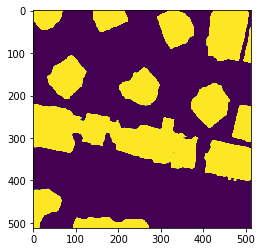

In [13]:
imgplot = plt.imshow(mask[:,:,1])

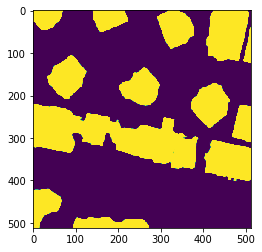

In [14]:
imgplot = plt.imshow(mask[:,:,0])

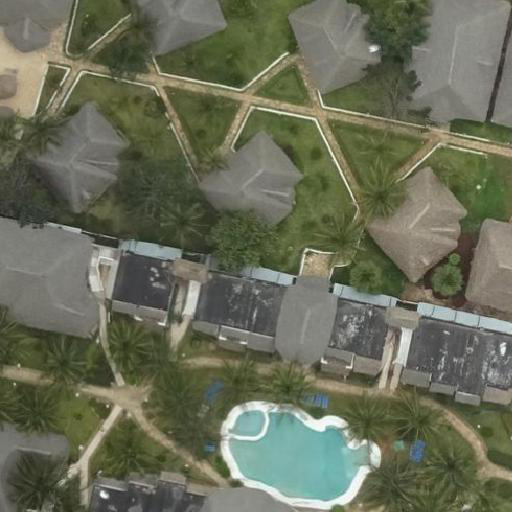

In [15]:
img

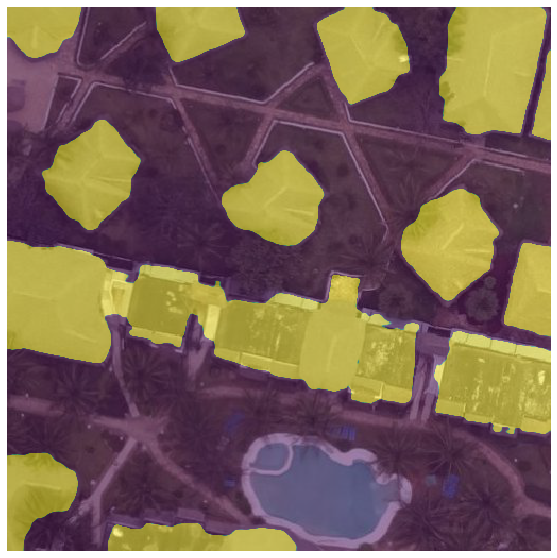

In [0]:
fig,ax = plt.subplots(1,1, figsize=(10,10))
img.show(ax=ax)
ax.imshow(mask[:,:,0], alpha=0.5)

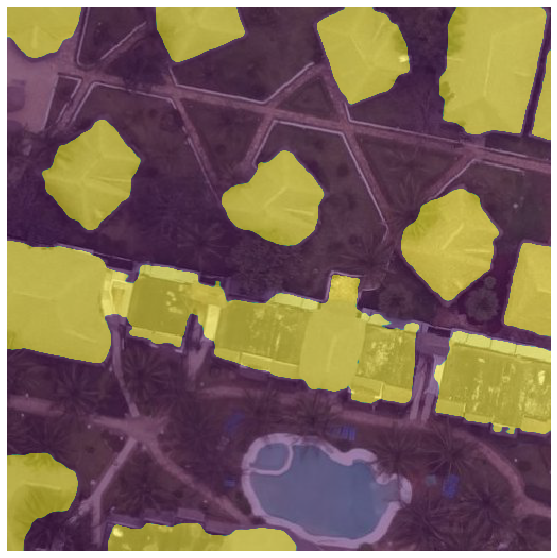

In [0]:
fig,ax = plt.subplots(1,1, figsize=(10,10))
img.show(ax=ax)
ax.imshow(mask[:,:,1], alpha=0.5)

### Plotting and filling the contour

#### Failed case

In [0]:
mask_thres = 0.7
epsilon = 10
min_area = 100.
erode = 5
dilate = 7

In [0]:
polys = []
mask = mask > (mask_thres*255)
    # erode and dilate
mask = cv2.erode(mask.astype('uint8'), np.ones((erode,erode),np.uint8), iterations=1)
mask = cv2.dilate(mask.astype('uint8'), np.ones((dilate,dilate),np.uint8), iterations=1)

    # label via connected components
_, instances = cv2.connectedComponents(mask.astype('uint8'))

    # make polys from instances
uniques = list(np.unique(instances))
print(uniques[0])
for b in uniques:
  poly = mask_to_polygons(instances==b,epsilon, min_area)
  print(poly)
  try: 
    if poly.type == 'MultiPolygon': 
      geo_coords = poly2coords(poly, img.affine_mat())
      polys.append(geo_coords)
            #else: print('not a MultiPolygon')
  except Exception as exc: print(f"{exc}")

0
MULTIPOLYGON (((0 0, 0 511, 511 511, 511 0, 0 0)))
'Tensor' object is not callable


In [0]:
len(polys)

0

#### Working cases of building contours

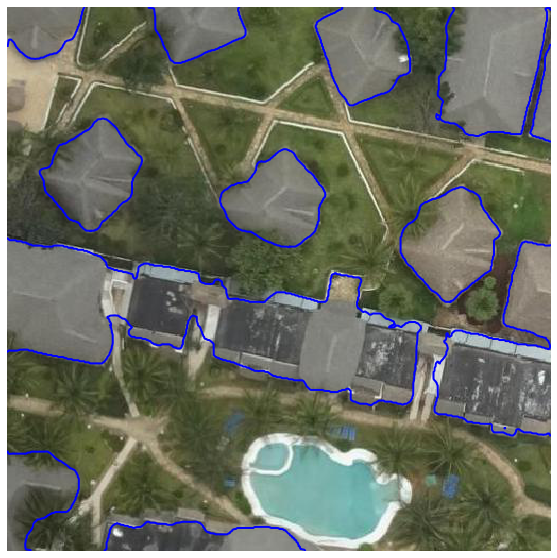

In [16]:
from skimage import measure

contours = measure.find_contours(mask[:,:,0], 0.002)

fig, ax = plt.subplots(figsize=(10,10))
img.show(ax=ax)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2,color='b')

In [0]:
contours

[array([[0.000000e+00, 7.199562e+01],
        [1.000000e+00, 7.129796e+01],
        [1.433857e+00, 7.100000e+01],
        [2.000000e+00, 7.095302e+01],
        ...,
        [3.400000e+01, 3.839024e-01],
        [3.500000e+01, 1.091558e-01],
        [3.600000e+01, 1.114194e-02],
        [3.603466e+01, 0.000000e+00]]), array([[0.000000e+00, 2.176295e+02],
        [6.625512e-01, 2.170000e+02],
        [1.000000e+00, 2.169948e+02],
        [2.000000e+00, 2.169983e+02],
        ...,
        [2.955036e-01, 1.350000e+02],
        [2.345352e-01, 1.340000e+02],
        [5.979011e-02, 1.330000e+02],
        [0.000000e+00, 1.328399e+02]]), array([[  0.      , 345.891488],
        [  1.      , 345.360195],
        [  2.      , 345.957347],
        [  2.044409, 346.      ],
        ...,
        [  1.372285, 314.      ],
        [  1.082889, 315.      ],
        [  1.      , 315.110578],
        [  0.      , 315.032419]]), array([[0.000000e+00, 5.089890e+02],
        [2.662974e-01, 5.080000e+02],
  

In [17]:
contour1 = []
for i in range(len(contours)):
  ele = []
  for j in range(len(contours[i])):
    y,x = contours[i][j]
    ele.append([x,y])
  contour1.append(np.array(ele))
contour1

[array([[7.199562e+01, 0.000000e+00],
        [7.129796e+01, 1.000000e+00],
        [7.100000e+01, 1.433857e+00],
        [7.095302e+01, 2.000000e+00],
        ...,
        [3.839024e-01, 3.400000e+01],
        [1.091558e-01, 3.500000e+01],
        [1.114194e-02, 3.600000e+01],
        [0.000000e+00, 3.603466e+01]]), array([[2.176295e+02, 0.000000e+00],
        [2.170000e+02, 6.625512e-01],
        [2.169948e+02, 1.000000e+00],
        [2.169983e+02, 2.000000e+00],
        ...,
        [1.350000e+02, 2.955036e-01],
        [1.340000e+02, 2.345352e-01],
        [1.330000e+02, 5.979011e-02],
        [1.328399e+02, 0.000000e+00]]), array([[345.891488,   0.      ],
        [345.360195,   1.      ],
        [345.957347,   2.      ],
        [346.      ,   2.044409],
        ...,
        [314.      ,   1.372285],
        [315.      ,   1.082889],
        [315.110578,   1.      ],
        [315.032419,   0.      ]]), array([[5.089890e+02, 0.000000e+00],
        [5.080000e+02, 2.662974e-01],
  

In [0]:
print(Polygon(contours[6]))

POLYGON ((105.1140796084585 406, 105.2010697475122 405, 105 404.8158944479234, 104.4448757399945 404, 104 403.8403047959952, 103 403.7127353790939, 102 403.4760500819663, 101 403.9765532926818, 100 403.9958341133596, 99.99533045215438 404, 100 404.0100810181306, 101 404.3508650201034, 101.059070681699 405, 101.2666737213038 406, 102 406.9918280811105, 103 406.7495372131571, 104 406.4225319098724, 105 406.0852154587719, 105.1140796084585 406))


In [0]:
poly = []
poly1=[]
for i in contour1:
  c = np.expand_dims(i.astype(np.float32), 1)
    # Convert it to UMat obj
  c = cv2.UMat(c)
  area = cv2.contourArea(c)
  if area>50:
    poly.append(Polygon(i))
    poly1.append(i)

In [0]:
len(poly)

12

##### Filling contour

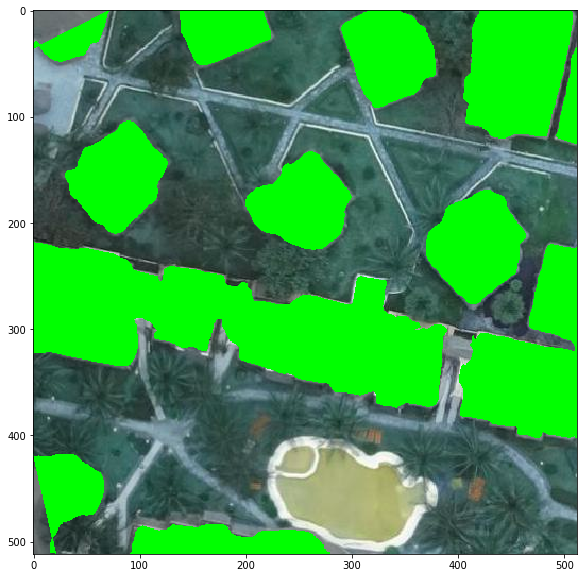

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
for i in range(len(poly1)):
  x = cv2.fillPoly(img2, pts = np.int32([poly1[i]]), color=(0,255,0))
ax.imshow(x)

In [0]:
[contours]

[[array([[0.000000e+00, 7.199562e+01],
         [1.000000e+00, 7.129796e+01],
         [1.433857e+00, 7.100000e+01],
         [2.000000e+00, 7.095302e+01],
         ...,
         [3.400000e+01, 3.839024e-01],
         [3.500000e+01, 1.091558e-01],
         [3.600000e+01, 1.114194e-02],
         [3.603466e+01, 0.000000e+00]]), array([[0.000000e+00, 2.176295e+02],
         [6.625512e-01, 2.170000e+02],
         [1.000000e+00, 2.169948e+02],
         [2.000000e+00, 2.169983e+02],
         ...,
         [2.955036e-01, 1.350000e+02],
         [2.345352e-01, 1.340000e+02],
         [5.979011e-02, 1.330000e+02],
         [0.000000e+00, 1.328399e+02]]), array([[  0.      , 345.891488],
         [  1.      , 345.360195],
         [  2.      , 345.957347],
         [  2.044409, 346.      ],
         ...,
         [  1.372285, 314.      ],
         [  1.082889, 315.      ],
         [  1.      , 315.110578],
         [  0.      , 315.032419]]), array([[0.000000e+00, 5.089890e+02],
         [2.662

### Cropping The Image

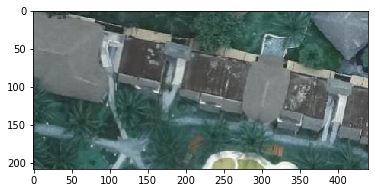

In [0]:
fig, ax = plt.subplots()
x,y,w,h = cv2.boundingRect(np.int32([poly1[8]]))
ROI = img2[y:y+h+50, x:x+w+50]
ax.imshow(ROI)

### Display All Crop Images

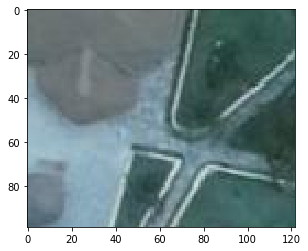

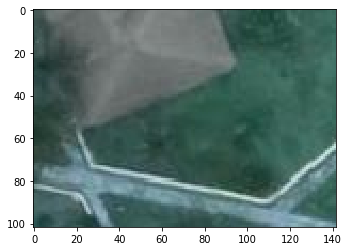

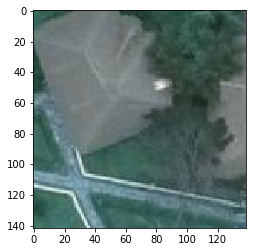

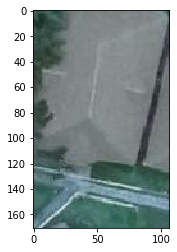

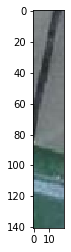

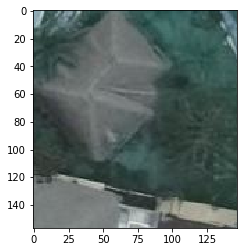

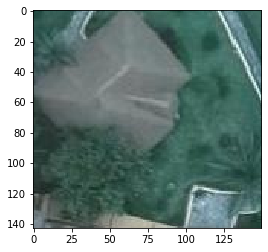

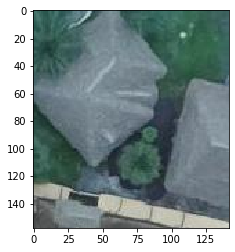

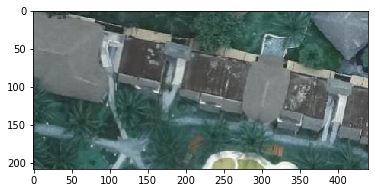

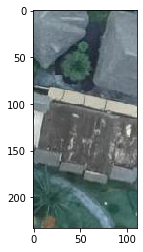

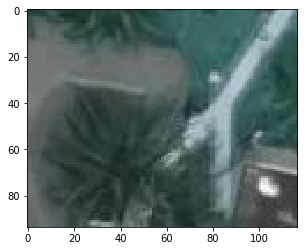

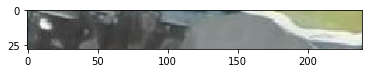

In [0]:
for i in range(len(poly1)):
  fig, ax = plt.subplots()
  x,y,w,h = cv2.boundingRect(np.int32([poly1[i]]))
  ROI = img2[y:y+h+50, x:x+w+50]
  ax.imshow(ROI)

### Saving All Cropped Images

In [0]:
df_contour = pd.DataFrame()
_id = []
img_names = []
contour_data = []
for i in range(len(poly1)):
  x,y,w,h = cv2.boundingRect(np.int32([poly1[i]]))
  ROI = img2[y:y+h+50, x:x+w+50]
  _id.append(i)
  img_names.append(f'IMG_025_0{i}.png')
  contour_data.append(poly1[i])
  cv2.imwrite(f"/content/drive/My Drive/deeplearning/building_detection/working_codes_of_project/classification_data/IMG_025_0{i}.png",ROI)

### Creating dataframe for storing contour

In [20]:
df_contour['id'] = _id
df_contour['image_names'] = img_names
df_contour['contour'] = contour_data
df_contour

,id,image_names,contour
0,0,IMG_025_00.png,"[[71.99561918089904, 0.0], [71.2979646825516, ..."
1,1,IMG_025_01.png,"[[217.62945497521068, 0.0], [217.0, 0.66255121..."
2,2,IMG_025_02.png,"[[345.891488023713, 0.0], [345.36019530159666,..."
3,3,IMG_025_03.png,"[[508.98904315240236, 0.0], [508.0, 0.26629738..."
4,4,IMG_025_04.png,"[[511.0, 125.99583824460423], [510.0, 125.8781..."
5,5,IMG_025_05.png,"[[78.0, 210.16179512091975], [77.0, 210.036317..."
6,6,IMG_025_06.png,"[[265.0, 225.1817490229478], [264.0, 225.46619..."
7,7,IMG_025_07.png,"[[417.0, 276.93939687089386], [416.0, 276.9953..."
8,8,IMG_025_08.png,"[[0.0, 217.4547470605729], [0.5325160934499911..."
9,9,IMG_025_09.png,"[[511.0, 402.7957197169548], [510.396966155060..."


# CLASSIFICATION



> classes in our model ['Complete', 'Incomplete', 'Foundation', 'Empty']



### LOAD THE LEARNED MODEL FOR CLASSIFICATION

#### MODEL PATH

In [0]:
classification_model_path = '/content/drive/My Drive/deeplearning/building_detection/znz-classify.zip (Unzipped Files)'

#### LOAD MODEL

In [0]:
learn_classi = load_learner(classification_model_path)

In [0]:
tfms = get_transforms(flip_vert=True, max_rotate=0.2, max_warp=0., max_zoom=1.1, max_lighting=0.4)

### Loading the working directory for classification

In [24]:
test_path = Path(f'/content/drive/My Drive/deeplearning/building_detection/working_codes_of_project/classification_data')
test_fns = [o for o in sorted(test_path.iterdir()) if '.png' in o.name]
print(len(test_fns))
print(test_fns)

12
[PosixPath('/content/drive/My Drive/deeplearning/building_detection/working_codes_of_project/classification_data/IMG_025_00.png'), PosixPath('/content/drive/My Drive/deeplearning/building_detection/working_codes_of_project/classification_data/IMG_025_01.png'), PosixPath('/content/drive/My Drive/deeplearning/building_detection/working_codes_of_project/classification_data/IMG_025_010.png'), PosixPath('/content/drive/My Drive/deeplearning/building_detection/working_codes_of_project/classification_data/IMG_025_011.png'), PosixPath('/content/drive/My Drive/deeplearning/building_detection/working_codes_of_project/classification_data/IMG_025_02.png'), PosixPath('/content/drive/My Drive/deeplearning/building_detection/working_codes_of_project/classification_data/IMG_025_03.png'), PosixPath('/content/drive/My Drive/deeplearning/building_detection/working_codes_of_project/classification_data/IMG_025_04.png'), PosixPath('/content/drive/My Drive/deeplearning/building_detection/working_codes_of_

### Prediction of images

In [25]:
preds = []
pred_classes = []
image_names = []
for fn in tqdm_notebook(test_fns):
    try: 
        img = open_image(fn)
        img = img.apply_tfms(tfms[1],resize_method=ResizeMethod.SQUISH, padding_mode='zeros')
        pred_class,pred_idx,outputs = learn_classi.predict(img)
        image_names.append(fn.name)
        preds.append(list(to_np(outputs)))
        pred_classes.append(str(pred_class))
    except Exception as exc: 
        print(f'{exc}') 
        preds.append([-1,-1,-1,-1])
        pred_classes.append('error')

In [26]:
pred_classes

['Complete',
 'Complete',
 'Complete',
 'Complete',
 'Complete',
 'Complete',
 'Complete',
 'Complete',
 'Complete',
 'Complete',
 'Complete',
 'Complete']

In [27]:
image_names

['IMG_025_00.png',
 'IMG_025_01.png',
 'IMG_025_010.png',
 'IMG_025_011.png',
 'IMG_025_02.png',
 'IMG_025_03.png',
 'IMG_025_04.png',
 'IMG_025_05.png',
 'IMG_025_06.png',
 'IMG_025_07.png',
 'IMG_025_08.png',
 'IMG_025_09.png']

In [31]:
[o.name for o in test_fns[:len(preds)]]

['IMG_025_00.png',
 'IMG_025_01.png',
 'IMG_025_010.png',
 'IMG_025_011.png',
 'IMG_025_02.png',
 'IMG_025_03.png',
 'IMG_025_04.png',
 'IMG_025_05.png',
 'IMG_025_06.png',
 'IMG_025_07.png',
 'IMG_025_08.png',
 'IMG_025_09.png']

### Creating dataFrame For prediction

In [0]:
df_pred_img = pd.DataFrame()

In [0]:
df_pred_img['id'] = range(len(image_names))
df_pred_img['image_names'] = image_names
df_pred_img['predict_classes'] = pred_classes

In [34]:
df_pred_img

,id,image_names,predict_classes
0,0,IMG_025_00.png,Complete
1,1,IMG_025_01.png,Complete
2,2,IMG_025_010.png,Complete
3,3,IMG_025_011.png,Complete
4,4,IMG_025_02.png,Complete
5,5,IMG_025_03.png,Complete
6,6,IMG_025_04.png,Complete
7,7,IMG_025_05.png,Complete
8,8,IMG_025_06.png,Complete
9,9,IMG_025_07.png,Complete


# PLOTTING FINAL DATA

## Simple testing

In [0]:
len(df_contour),len(df_pred_img)

(12, 12)

In [0]:
# extracting prediction
x = df_pred_img[df_pred_img['image_names']=='IMG_025_011.png']['predict_classes']

In [0]:
x.values[0]

'Complete'

In [0]:
x[2]

'Complete'

In [0]:
df_contour[df_contour['id']==1]['image_names'][1]

'IMG_025_01.png'

In [0]:
# extracting contour
y = df_contour[df_contour['image_names']=='IMG_025_02.png']['contour']

In [0]:
y.values[0]

array([[345.891488,   0.      ],
       [345.360199,   1.      ],
       [345.957347,   2.      ],
       [346.      ,   2.044409],
       ...,
       [314.      ,   1.372285],
       [315.      ,   1.082889],
       [315.110577,   1.      ],
       [315.032419,   0.      ]])

## Final plot 

### simple tests

In [0]:
for i,j in enumerate(image_names):
  x = df_pred_img[df_pred_img['image_names']==j]['predict_classes'].values[0]
  print(x)
  y = df_contour[df_contour['image_names']==j]['contour'].values[0]
  print(y,'\n')

Complete
[[7.199562e+01 0.000000e+00]
 [7.129796e+01 1.000000e+00]
 [7.100000e+01 1.433852e+00]
 [7.095302e+01 2.000000e+00]
 ...
 [3.839001e-01 3.400000e+01]
 [1.091523e-01 3.500000e+01]
 [1.113753e-02 3.600000e+01]
 [0.000000e+00 3.603465e+01]] 

Complete
[[2.176295e+02 0.000000e+00]
 [2.170000e+02 6.625523e-01]
 [2.169948e+02 1.000000e+00]
 [2.169983e+02 2.000000e+00]
 ...
 [1.350000e+02 2.955023e-01]
 [1.340000e+02 2.345322e-01]
 [1.330000e+02 5.978635e-02]
 [1.328399e+02 0.000000e+00]] 

Complete
[[0.000000e+00 4.180659e+02]
 [1.246878e-01 4.190000e+02]
 [9.290104e-01 4.200000e+02]
 [1.000000e+00 4.200670e+02]
 ...
 [1.900000e+01 5.103999e+02]
 [2.000000e+01 5.107155e+02]
 [2.100000e+01 5.107258e+02]
 [2.156469e+01 5.110000e+02]] 

Complete
[[ 91.457217 511.      ]
 [ 92.       510.502337]
 [ 93.       510.083203]
 [ 93.03275  510.      ]
 ...
 [277.       510.004911]
 [278.       510.284416]
 [279.       510.365462]
 [279.940406 511.      ]] 

Complete
[[345.891488   0.      ]
 [

### Plot

> 1. [docs1 opencv](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contours_begin/py_contours_begin.html)
2. [how to plot a contour](https://stackoverflow.com/questions/52212239/opencv-plot-contours-in-an-image)
3. [geeeksforgeeks](https://www.geeksforgeeks.org/find-and-draw-contours-using-opencv-python/)

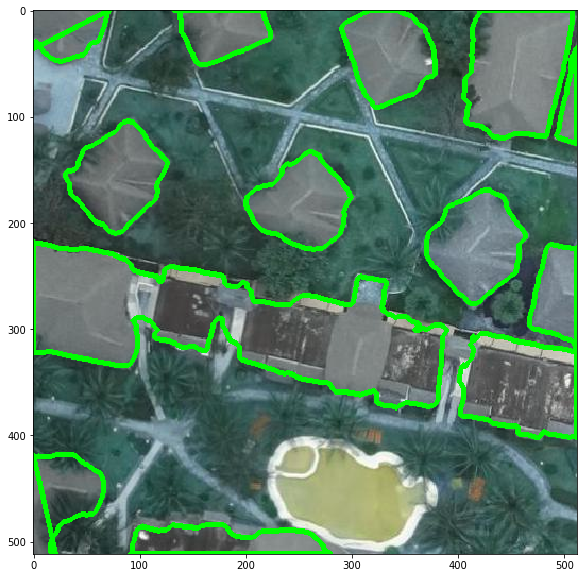

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
for i,j in enumerate(image_names):
  x = df_pred_img[df_pred_img['image_names']==j]['predict_classes'].values[0]
  y = df_contour[df_contour['image_names']==j]['contour'].values[0]
  if x=='Complete':
    final_plot = cv2.drawContours(img2, [y.astype(int)], 0, (0,255,0), 3)
  elif x=='Incomplete':
    final_plot = cv2.drawContours(img2, [y.astype(int)], 0, (255,0,0), 3)
  elif x=='Foundation':
    final_plot = cv2.drawContours(img2, [y.astype(int)], 0, (0,0,255), 3)
  else:
    final_plot = cv2.drawContours(img2, [y.astype(int)], 0, (255,255,255), 3)
ax.imshow(final_plot)


### Saving the final image



> Go through the link to know how read,write and display the image in opencv<br>
1.[stackoverflow](https://stackoverflow.com/questions/28759253/how-to-crop-the-internal-area-of-a-contour)



In [36]:
cv2.imwrite('/content/drive/My Drive/deeplearning/building_detection/working_codes_of_project/final_plot.png',final_plot)

True